In [ ]:
# First, mount your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Navigate to this directory using commands like %pwd and %cd
%cd drive/MyDrive/ECSE551/Project1/Project1.1/

/content/drive/.shortcut-targets-by-id/1D79RsbDYba-CaF5Wcir7xE6SGxQ7_TQO/Project1/Project1.1


We begin by importing three classes made from scratch: LogisticRegression, KFoldSplitSet, and NestedCV. In addition to these, numpy, pandas, and itertools is also imported.



In [ ]:
from LogisticRegression import LogisticRegression
from SplitSet import SplitSet
from NestedCrossValidation import NestedCV, Accu_eval
import pandas as pd
import numpy as np
import itertools

First, the hepatitis dataset must be processed to appropriately train the logistic classifier. A header row is added and a class vector is constructed from the last column of the dataset.

In [ ]:
# Load the data
hepatitis_set = pd.read_csv('Hepatits.csv')
hepatitis_headers = ['Ascites', 'Varices', 'Bilirubin', 'Alk Phosphate',
                     'Sgot', 'Albumin', 'Protime', 'Histology', 'Class']

hepatitis_set.columns = hepatitis_headers

# Get the labels from last column
X = hepatitis_set.iloc[:, :-1]
Y = hepatitis_set.iloc[:, -1]

# Normalize the data per column
X = (X - X.mean()) / X.std()

An automated process was designed to choose candidate models that had the highest accuracy based on a nested cross validation algorithm. A hyperparameter grid was constructed to identify the best learning rate, regularization, and norm penalty.

In [ ]:

hyperparameters = {
    'lr': [0.0001, 0.001, 0.03],
    'reg': ['l1', 'l2'],
    'norm_penalty': [0, 0.3, 0.8, 1]
}
hyper_perms = list(itertools.product(*hyperparameters.values()))

# Remove l2 with 0 norm penalty since it's the same as l1 with 0 norm penalty (no regularization)
hyper_perms = [perm for perm in hyper_perms if [perm[1], perm[2]] != ['l2', 0]]

A nested cross validation is performed with 10 outer folds to procure candidate models that perform the best in the grid search validation process.

In [ ]:
# Perform k-fold cross validation on each hyperparameter permutation to find the best one
nested_cv = NestedCV(outer_folds=10)

# Keep track of the top 5 best hyperparameter permutations
best_accuracy = 0
best_perm = None
top_5 = []

for perm in hyper_perms:
    model = LogisticRegression(perm[0], perm[1], perm[2], early_stopping=True)
    accuracy = nested_cv.k_fold_cross_validation(model, X, Y)

    # Update the top 5 best hyperparameter permutations
    if len(top_5) < 5:
        top_5.append((accuracy, perm))
    elif accuracy > top_5[0][0]:
        top_5[0] = (accuracy, perm)
        top_5.sort(key=lambda x: x[0])

    if accuracy > best_accuracy:
        best_accuracy = accuracy

# Print the top 5 best hyperparameter permutations
print("Top 5 best hyperparameter permutations:")
top_5.sort(key=lambda x: x[0])
for i, perm in enumerate(top_5):
    print("{}. Accuracy: {:.2f}%, Hyperparameters: {}".format(i+1, perm[0]*100, perm[1]))

# Get the best model
best_model = LogisticRegression(top_5[-1][1][0], top_5[-1][1][1], top_5[-1][1][2], early_stopping=True)

Top 5 best hyperparameter permutations:
1. Accuracy: 74.41%, Hyperparameters: (0.0001, 'l2', 0.3)
2. Accuracy: 74.71%, Hyperparameters: (0.0001, 'l2', 1)
3. Accuracy: 75.00%, Hyperparameters: (0.0001, 'l1', 0.8)
4. Accuracy: 75.00%, Hyperparameters: (0.0001, 'l1', 1)
5. Accuracy: 75.29%, Hyperparameters: (0.0001, 'l1', 0.3)


The best performing models have a learning rate of 0.0001 with 2000 max iterations. In the case of this hepatitis dataset, it does not appear as though a certain type of regularization increases the performance of the model very much as L1 and L2 both can achieve a similar accuracy.

We can now do some analysis with the best model selected. First let's see how it used regularization to place less importance on some features.

In [ ]:
# Generate splits
splits = SplitSet()
X_train, X_test, Y_train, Y_test = splits.split(X, Y, test_size=0.2)
x_train, x_val, y_train, y_val = splits.split(X_train, Y_train, test_size=0.2)

# Train the best model
best_model.fit(x_train, y_train, x_val, y_val)

# Check the weights per feature
headers = ['Intercept', 'Ascites', 'Varices', 'Bilirubin', 'Alk Phosphate',
            'Sgot', 'Albumin', 'Protime', 'Histology']
weights = best_model.w
data = {'Feature': headers, 'Weight': weights}
weights_df = pd.DataFrame(data)

# Order the weights by absolute value
weights_df['Weight'] = weights_df['Weight'].abs()
weights_df.sort_values(by=['Weight'], inplace=True, ascending=False)
print("\nWeights per feature:")
print(weights_df)


Weights per feature:
         Feature    Weight
2        Varices  1.155868
1        Ascites  0.512123
6        Albumin  0.423382
5           Sgot  0.391785
8      Histology  0.346223
7        Protime  0.262433
3      Bilirubin  0.197524
0      Intercept  0.133795
4  Alk Phosphate  0.112711


It appears as though some features are more important than others. For example, the weights on "Alk Phosphate", "Protime", and "Bilirubin" seem to often be less important than the other features. We can see what happens if we remove these features entirely.

In [ ]:
# Test the best model with subset of features
X_reduced = X.drop(columns=['Bilirubin', 'Alk Phosphate', 'Protime'])
accuracy_reduced = nested_cv.k_fold_cross_validation(best_model, X_reduced, Y)
print("Accuracy with reduced features: ", accuracy_reduced)
print("Difference in accuracy: ", best_accuracy - accuracy_reduced)

Accuracy with reduced features:  0.7323529411764707
Difference in accuracy:  0.020588235294117574


When we remove these features, the accuracy does not change much (2.1% drop). Hence, while not particularly useful, these features still add some value to the accuracy of the model.

We can also see if adding new features increases the performance. Here we will try concatenating the squares of each feature.

In [ ]:
# Create new features that are squares of the old features and add them to the dataset
X_squared = X.apply(np.square)
X_enhanced = pd.concat([X, X_squared], axis=1)
accuracy_enhanced = nested_cv.k_fold_cross_validation(best_model, X_enhanced, Y)
print("Accuracy with enhanced features: ", accuracy_enhanced)
print("Difference in accuracy: ", best_accuracy - accuracy_enhanced)

Accuracy with enhanced features:  0.7205882352941176
Difference in accuracy:  0.032352941176470584


In this case, appending the extra features actually decreased performance by 3.23%. Hence, for this dataset, the extra features hurt the model.

Early stopping is enforced by observing the performance of the model on a validation set during training. We can enforce this by saying that if the accuracy of prediction does not increase by more than 0.001 over 250 consecutive iterations, the model stops training. Let's see how this affects performance on a held out test set.

Test set accuracy with no stopping (2000 iterations): 0.7536231884057971
Time elapsed: 0.33824610710144043


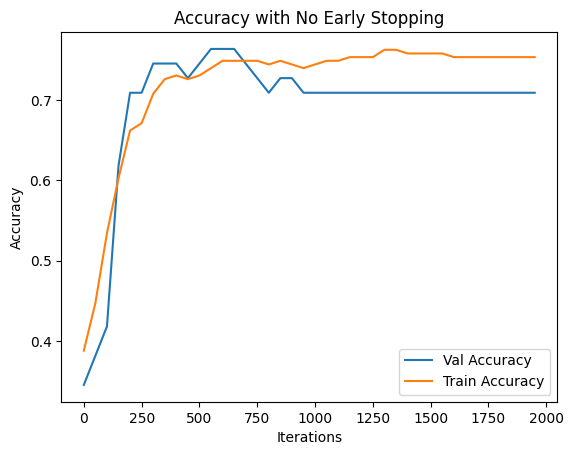

Test set accuracy with stopping after 800 iterations: 0.782608695652174
Time elapsed: 0.1436324119567871


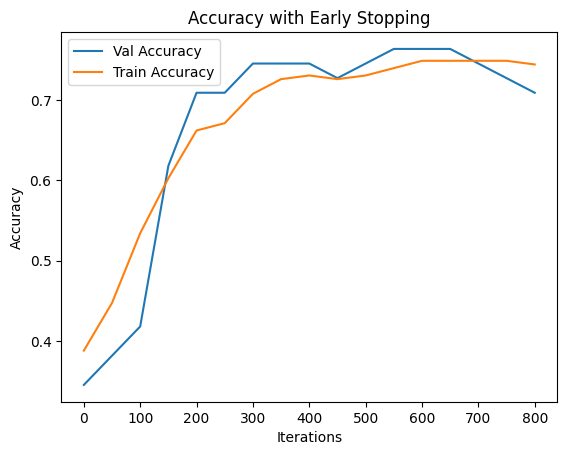

In [ ]:
import matplotlib.pyplot as plt
import time

# Evaluate the best model with no early stopping
timer = time.time()
best_model.early_stopping = False
iterations, val_accuracies, train_accuracies = best_model.fit(x_train, y_train, x_val, y_val)
Y_pred = best_model.predict(X_test)
accuracy = np.mean(Y_pred == Y_test)
print("Test set accuracy with no stopping (2000 iterations):", accuracy)
print("Time elapsed:", time.time() - timer)

# Make a plot of the accuracy vs iterations
plt.plot(iterations, val_accuracies, label='Val Accuracy')
plt.plot(iterations, train_accuracies, label='Train Accuracy')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy with No Early Stopping")
plt.legend()
plt.show()

# Evaluate model with early stopping
timer = time.time()
best_model.early_stopping = True
iterations, val_accuracies, train_accuracies = best_model.fit(x_train, y_train, x_val, y_val)
Y_pred = best_model.predict(X_test)
accuracy = np.mean(Y_pred == Y_test)
print(f"Test set accuracy with stopping after {iterations[-1]} iterations:", accuracy)
print("Time elapsed:", time.time() - timer)

# Make a plot of the accuracy vs iterations
plt.plot(iterations, val_accuracies, label='Val Accuracy')
plt.plot(iterations, train_accuracies, label='Train Accuracy')
plt.plot()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy with Early Stopping")
plt.legend()
plt.show()

Stopping training early appears to have some computational savings while helping performance by nearly 3% on the held out test set. Stopping training early appears to have some computational savings while not sacrificing very much performance. We can see that the performance on the validation set is preserved when we stop early. With a looser stopping criteria, less performance will be sacrificed on the test set.

Finally, we can compare the best model found against some simple benchmarks.

In [ ]:
# Random classifier that predicts 50/50
Y_pred_random = np.random.randint(0, 2, len(Y_test))
accuracy = np.mean(Y_pred_random == Y_test)
print("Random classifier accuracy:", accuracy)

# Majority classifier that predicts all 1's
Y_pred_majority = np.ones(len(Y_test))
accuracy = np.mean(Y_pred_majority == Y_test)
print("Majority classifier accuracy:", accuracy)

# Minority classifier that predicts all 0's
Y_pred_minority = np.zeros(len(Y_test))
accuracy = np.mean(Y_pred_minority == Y_test)
print("Minority classifier accuracy:", accuracy)

# Print the models found by nested cross validation
print("\nModels found by nested cross validation:")
for i, model in enumerate(top_5):
    print("{}. Accuracy: {:.2f}%, Hyperparameters: {}".format(i+1, model[0]*100, model[1]))

Random classifier accuracy: 0.4927536231884058
Majority classifier accuracy: 0.4927536231884058
Minority classifier accuracy: 0.5072463768115942

Models found by nested cross validation:
1. Accuracy: 74.41%, Hyperparameters: (0.0001, 'l2', 0.3)
2. Accuracy: 74.71%, Hyperparameters: (0.0001, 'l2', 1)
3. Accuracy: 75.00%, Hyperparameters: (0.0001, 'l1', 0.8)
4. Accuracy: 75.00%, Hyperparameters: (0.0001, 'l1', 1)
5. Accuracy: 75.29%, Hyperparameters: (0.0001, 'l1', 0.3)


The models found via the nested cross fold validation all are superior to random, minority, and majority baselines.